In [61]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import pandas as pd
import numpy as np
import librosa
import seaborn as sns
import os
import json
import IPython.display as ipd
import soundfile as sf
import torch
import collections
import h5py
import timm
import torch.nn as nn
import onnxruntime as ort
# import torchaudio
import onnx
# import tensorflow as tf
# import tensorflow_hub as hub
# import tf2onnx
import onnx
import onnxruntime as ort
from onnxsim import simplify
from scipy.special import expit
from collections import Counter



from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from itertools import chain
from os.path import join as pjoin
from torchaudio.transforms import AmplitudeToDB, MelSpectrogram
from copy import deepcopy
from typing import Callable
from nnAudio.Spectrogram import CQT1992v2
# import leaf_audio_pytorch.frontend as frontend
from torchaudio.transforms import TimeMasking, FrequencyMasking
from shutil import copyfile
from torchaudio.transforms import Resample

# from code_base.utils import parallel_librosa_load, groupby_np_array, stack_and_max_by_samples, load_pp_audio
# from code_base.utils.constants import SAMPLE_RATE, N_CLASSES_2021_2022
from code_base.utils.onnx_utils import convert_to_onnx
from code_base.models import WaveCNNClasifier, WaveCNNAttenClasifier, WaveTDNNClasifier, RandomFiltering
from code_base.models.blocks import TraceableMelspec, NormalizeMelSpec, GeMFreqFixed
from code_base.utils.metrics import score_numpy
# from code_base.models.wave_clasifier import WaveCNNAttenClasifier
from code_base.datasets import WaveDataset, WaveAllFileDataset
from code_base.utils import load_json, write_json
from code_base.utils.audio_utils import get_librosa_load
# from code_base.augmentations.background_noise import AddBackgoundFromSoundScapes
# from code_base.augmentations.transforms import BackgroundNoise, Compose, GaussianNoise, PinkNoise, OneOf
# from code_base.forwards import MultilabelClsForwardLongShort
# from code_base.utils.onnx_utils import ONNXEnsemble, convert_to_onnx
from code_base.augmentations.transforms import (
    BackgroundNoise,
    Compose,
    GaussianNoise,
    OneOf,
    PinkNoise,
)
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [2]:
# df = pd.read_csv(
#     "/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv1.csv",
#     converters={"secondary_labels": eval, "all_labels": eval}
# )
# df = pd.read_csv(
#     "/home/vova/data/exps/birdclef_2024/dfs/full_noduplsV3_scored_meta_prev_comps_extended_2024SecLabels.csv",
#     converters={"secondary_labels": eval, "all_labels": eval}
# )
df = pd.read_csv(
    "/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_2024_classes/train_metadata_noduplV3_extended_2024SecLabels.csv",
    converters={"secondary_labels": eval, "all_labels": eval}
)
# taxonomy = pd.read_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/eBird_Taxonomy_v2021.csv")
# previous_soundscapes = pd.read_csv(
#     "/home/vova/data/exps/birdclef_2024/my_2023_data/soundscapes_nocall/v1_no_call_meta_fixed.csv"
# )
# df = pd.read_csv("/home/vova/data/exps/BirdCLEF_2023/xeno_canto/train_metadata_extended_shorten_and_2023x_v1.csv")
# df.head()

In [3]:
scored_birds = load_json(
    "/home/vova/data/exps/birdclef_2024/scored_birds/sb_2024.json"
)

In [ ]:
df[df["duration_s"] <=5]

In [ ]:
train_dataset_full = WaveAllFileDataset(
    # df=df,
    df=df[df["duration_s"] <=5].reset_index(drop=True),
    # root="/home/vova/data/exps/birdclef_2024/birdclef_2024/train_features/",
    root="/home/vova/data/exps/birdclef_2024/birdclef_2024/train_audio",
    label_str2int_mapping_path="/home/vova/data/exps/birdclef_2024/class_mappings/bird2int_2024.json",
    precompute=False,
    n_cores=4,
    debug=False,
    segment_len=5,
    sample_id=None,
    late_normalize=True,
    use_h5py=False,
    load_normalize=False,

    use_audio_cache=True,
    test_mode=False
)

id2bird_vova = {v:k for k,v in train_dataset_full.label_str2int.items()}

In [ ]:
np.abs(train_dataset_full.test_audio_cache["au"]).max()

In [ ]:
np.abs(train_dataset_full[0][0]).max()

# Google Model

In [ ]:
import tensorflow_hub as hub

In [ ]:
model_path = 'https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8'
model = hub.load(model_path)
model_labels_df = pd.read_csv(hub.resolve(model_path) + "/assets/label.csv")

In [ ]:
model

In [ ]:
set(scored_birds) - set(model_labels_df["ebird2021"])

In [ ]:
scored_birds = pd.Series(scored_birds)

In [ ]:
scored_birds[scored_birds.apply(lambda x: x.startswith("indrol"))]

In [ ]:
model_labels_df[model_labels_df["ebird2021"].apply(lambda x: x.startswith("bkrfla"))]

In [ ]:
model_labels_df[model_labels_df["ebird2021"].apply(lambda x: x.startswith("indrol"))]

In [ ]:
model_labels_df.shape

In [ ]:
id2bird_google = model_labels_df["ebird2021"].to_dict()

In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

In [ ]:
import tensorflow as tf

In [ ]:
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

In [ ]:
with tf.device('/gpu:0'):
    model_output = model.infer_tf(np.random.uniform(size=(64, 5*32000)))

In [ ]:
model_output

In [ ]:
def google_postprocessor_v8(input):
    return expit(input["label"].numpy())

In [ ]:
REARRANGE_INDICES = np.array([ 7717,  4041,   354,  4914,  1643,  5186,  4749,  4621,  2750,
        1017,  1802,  4524,  3890,  7289,  8703,  6664,  7355,  9680,
       10237,  1372,  4096,  5373,  6389,  5418,  2593,  4402,  4003,
        6925,  3922, 10533,  7725,  1507,  5486,  8873,  7804,  4250,
        5572,   901,  3624,  1031,  2707,  4791,  4609,  1692,  1016,
        5120,   971, 10611,  2881,  3825,  6772,  4489,  1297,  1661,
        7352,  9047,  2607,  1788,  8236,  6933,  4728,  6906,  5039,
        4579,  2623,  5385, 10065,  7167,   967, 10050,  4522,  7359,
        4754,  4942,  7436,  2598,  5235,  2601,   727,  3913,  6921,
        8530,  6725,  5975,  8832,  4611,  5047,  4174,  9961,   990,
        8029,  6260,  1594,  6649,  3792,  3462,  9378,  5145,  4076,
        1964,  6922,  4623,  4602,  2524,  6315,  2815,  7666,  5718,
        9836,  4753,   362,  5982,  2103,  9888,  2898,  9422,  6268,
        5148,  1600,  7998,   577,  2627, 10584,  5409,  4618,  4794,
        8784,  3697,  7476,  4855,   326,   364,  6823, 10056,  3218,
        4603,  4619,  3894,  1417,  6726,  3221,   315,  2605,  2612,
        2622,   600,  5097, 10031,  3904,  5417,  6068,   347,  3886,
        4601,  3958,  9676,  1704,  1353,  8767, 10058,  2776,  4614,
       10299,  2201,  5115,  4112,  4006,   337,  4636,  6271,  2599,
        6736,  3176,   360, 10077,  1715,  2643, 10928,  9408,  3551,
       10377,   366,  1789, 10620,  3207,  3126,  7483,  8444])

In [ ]:
expit(model_output["label"].numpy())[:,REARRANGE_INDICES].shape

In [ ]:
logits

In [ ]:
len(train_dataset_full)

In [ ]:
probs

In [ ]:
wave, target, dfidx, start, end = train_dataset_full[0]

print("Target IDS:", np.where(target > 0)[0])
print("Birds: ", [id2bird_vova[el] for el in np.where(target > 0)[0]])

output = model.infer_tf(wave[np.newaxis, :])
probs = torch.sigmoid(torch.from_numpy(output[0].numpy()))[0]

print("Predicted IDS:", np.where(probs > 0.5)[0])
print("Birds: ", [id2bird_google[el] for el in np.where(probs > 0.5)[0]])

In [ ]:
ipd.Audio(wave, rate=32000)

In [ ]:
plt.plot(wave)

In [ ]:
probs = torch.sigmoid(torch.from_numpy(output["label"].numpy()))

In [ ]:
print("Predicted IDS:", np.where(probs > 0.5)[0])
print("Birds: ", [id2bird_google[el] for el in np.where(probs > 0.5)[0]])

In [ ]:
probs

# Convert to ONNX

In [ ]:
model_path = 'https://kaggle.com/models/google/bird-vocalization-classifier/frameworks/TensorFlow2/variations/bird-vocalization-classifier/versions/4'
hub_model = hub.load(model_path)

In [ ]:
# Define a wrapper model
class HubModelWrapper(tf.keras.Model):
    output_names = ["logits", "embeddings"]
    
    def __init__(self, hub_model):
        super(HubModelWrapper, self).__init__()
        self.hub_model = hub_model
    
    def call(self, inputs):
        return self.hub_model.infer_tf(inputs)

# Create an instance of the wrapper model
model = HubModelWrapper(hub_model)

# Compile the model (necessary for saving)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Define input shape for the model, assuming the input size as given in the original post
input_shape = (None, 5*32000)  # Adjust based on the actual expected input shape
model.build([input_shape])  # This is necessary to create the model layers

In [ ]:
# # Save the model locally as a SavedModel
# saved_model_path = './google_model_onnx/'
# model.save('./google_model_onnx/model.keras')

In [ ]:
spec = (tf.TensorSpec((None, 5*32000), tf.float32, name="input"),)

# Convert
model_proto, external_tensor_storage = tf2onnx.convert.from_keras(
    model, 
    input_signature=spec, 
    output_path='./google_model_onnx/model.onnx', 
    opset=12
)

# Save the ONNX model
onnx.save(model_proto, './google_model_onnx/model.onnx')

In [ ]:
sess = ort.InferenceSession('./google_model_onnx/model.onnx')

# Create Processed Google Model

## Train Data

In [ ]:
df["id"] = df["filename"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

In [ ]:
train_data_google_results = glob(
    # "../google_bird_predictions/train_data/*.csv"
    # "../google_bird_predictions/add_scored_data/*.csv"
    "../google_bird_predictions/unlabeled_data/*.csv"
)
train_data_google_results = pd.concat([pd.read_csv(el) for el in train_data_google_results]).reset_index(drop=True)

In [ ]:
train_data_google_results = train_data_google_results.drop_duplicates("row_id").reset_index(drop=True)

In [ ]:
train_data_google_results["id"] = train_data_google_results["row_id"].apply(lambda x: x.split("_")[0])
train_data_google_results["final_second"] = train_data_google_results["row_id"].apply(lambda x: int(x.split("_")[1]))

In [ ]:
train_data_google_results.to_csv(
    "../google_bird_predictions/unlabeled_data/unlabeled_data_google_bird_model_pseudo.csv", 
    index=False
)

In [ ]:
missing_birds = set(scored_birds) - set(train_data_google_results.columns[1:])

In [ ]:
google_birds = [el for el in scored_birds if el not in missing_birds]
# train_data_google_results.columns[1:-2]

### Compute metric

In [ ]:
train_data_google_results

In [ ]:
train_data_google_results_aggr = train_data_google_results.groupby("id").apply(
    lambda sub_df: sub_df[google_birds].max(axis=0)
).reset_index()

In [ ]:
train_data_google_results_aggr

In [ ]:
df_without_missing = df[~df["all_labels"].apply(lambda x: any(el in missing_birds for el in x))].reset_index(drop=True)

In [ ]:
set(df["id"]) - set(train_data_google_results["id"])

In [ ]:
train_data_google_results_aggr = train_data_google_results_aggr[
    train_data_google_results_aggr["id"].isin(df_without_missing["id"])
].reset_index(drop=True)

In [ ]:
df_without_missing = df_without_missing.sort_values("id").reset_index(drop=True)
train_data_google_results_aggr = train_data_google_results_aggr.sort_values("id").reset_index(drop=True)

assert (df_without_missing["id"] == train_data_google_results_aggr["id"]).all()

In [ ]:
gt = np.stack(df_without_missing["all_labels"].apply(lambda gt: np.array([float(el in gt) for el in google_birds])).to_list())
pred = train_data_google_results_aggr[google_birds].values

In [ ]:
gt

In [ ]:
pred

In [ ]:
score_numpy(gt, pred)

### Prepare DF

In [4]:
def merge_intervals(data):
    if not data:
        return []

    # Sort by start time
    data.sort(key=lambda x: x[0])

    # Initialize the list of merged intervals with the first interval
    merged = [data[0]]

    for current in data[1:]:
        prev_end = merged[-1][1]
        current_start = current[0]
        current_end = current[1]
        current_labels = set(current[2])  # Convert list of labels to a set for union operation

        # Check if the current interval overlaps or is adjacent to the previous interval
        if current_start <= prev_end:
            # Merge the intervals
            merged[-1][1] = max(prev_end, current_end)
            # Union of the labels
            merged[-1][2] = list(set(merged[-1][2]).union(current_labels))
        else:
            # If no overlap, add the current interval to the result
            current[2] = list(current_labels)  # Convert back the set to list
            merged.append(current)

    # Ensure the labels are in list format, not a set
    for interval in merged:
        interval[2] = list(set(interval[2]))

    return merged

def create_timewise_label(row):
    real_label = set(row["all_labels"])
    result = [
        set(labels) & real_label for labels in row["all_labels_pred"]
    ]
    return [
        [end-5, end, list(labels)] for labels, end in zip(result, row["final_second"]) if len(labels) > 0
    ]

def trim_last_label_if_needed(row):
    if not row["label_second"]:
        return []
    row["label_second"][-1][1] = min(row["duration_s"], row["label_second"][-1][1])
    return row["label_second"]

In [ ]:
all_google_birds = train_data_google_results.columns[1:-2]

In [ ]:
train_data_google_results["all_labels"] = train_data_google_results.apply(
    lambda x: list(all_google_birds[expit(x[all_google_birds].values.astype(np.float32)) > 0.5]), 
    axis=1
)

In [ ]:
train_data_google_results["all_labels"] = train_data_google_results["all_labels"].apply(list)

In [ ]:
pd.Series(list(chain(*df["all_labels"].to_list()))).value_counts().head(20)

In [ ]:
pd.Series(list(chain(*train_data_google_results["all_labels"].to_list()))).value_counts().head(20)

In [ ]:
train_data_google_results_for_merge = train_data_google_results.groupby("id").agg({
    "all_labels": list,
    "final_second": list
}).reset_index()

In [ ]:
df.shape

In [ ]:
df = df.merge(train_data_google_results_for_merge, on="id", how="left", suffixes=("", "_pred"))

In [ ]:
df.shape

In [ ]:
df["label_second"] = df.apply(create_timewise_label, axis=1)

In [ ]:
df["label_second"] = df["label_second"].apply(merge_intervals)

In [ ]:
df["label_second"] = df.apply(trim_last_label_if_needed, axis=1)

In [ ]:
df[df["label_second"].apply(lambda x: x[-1][1] if x else 0) > df["duration_s"]]

In [ ]:
df[["all_labels", "all_labels_pred", "label_second"]]

In [ ]:
missing_label_mask = df["primary_label"].isin(missing_birds)

In [ ]:
missing_label_mask.sum()

In [ ]:
df.loc[missing_label_mask, "label_second"]

In [ ]:
df.loc[missing_label_mask, "label_second"] = df.loc[missing_label_mask].apply(
    lambda row: [[0, row["duration_s"], row["all_labels"]]], axis=1
)

In [ ]:
df.loc[missing_label_mask, "label_second"]

In [ ]:
df[["all_labels", "all_labels_pred", "label_second"]]

In [ ]:
missing_birds_after_filter = (
    set(scored_birds) - set(chain(*df["label_second"].apply(lambda x: list(chain(*[el[-1] for el in x]))).to_list()))
)
missing_birds_after_filter

In [ ]:
df.loc[df["primary_label"].isin(missing_birds_after_filter), "label_second"] = df.loc[df["primary_label"].isin(missing_birds_after_filter)].apply(
    lambda row: [[0, row["duration_s"], row["all_labels"]]], axis=1
)

In [ ]:
missing_birds_after_filter = (
    set(scored_birds) - set(chain(*df["label_second"].apply(lambda x: list(chain(*[el[-1] for el in x]))).to_list()))
)
missing_birds_after_filter

In [ ]:
df = df[df["label_second"].apply(len) > 0].reset_index(drop=True)

In [ ]:
df.shape

In [ ]:
df.to_csv(
    # "/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv1_GBirdV1.csv",
    # "/home/vova/data/exps/birdclef_2024/dfs/full_noduplsV3_scored_meta_prev_comps_extended_2024SecLabels_GBirdV1.csv",
    "/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_2024_classes/train_metadata_noduplV3_extended_2024SecLabels_GBirdV1.csv",
    index=False
)

#### Unlabeled

In [60]:
def create_timewise_label(row):
    return [
        [end-5, end, labels] for labels, end in zip(row["all_labels"], row["final_second"]) if len(labels) > 0
    ]

def most_frequent_element(lst):
    if not lst:
        return None
    count = Counter(lst)
    return count.most_common(1)[0][0]

In [13]:
train_pseudo = pd.read_csv("../google_bird_predictions/train_data/train_data_google_bird_model_pseudo.csv")
unlabeled_pseudo = pd.read_csv("../google_bird_predictions/unlabeled_data/unlabeled_data_google_bird_model_pseudo.csv")

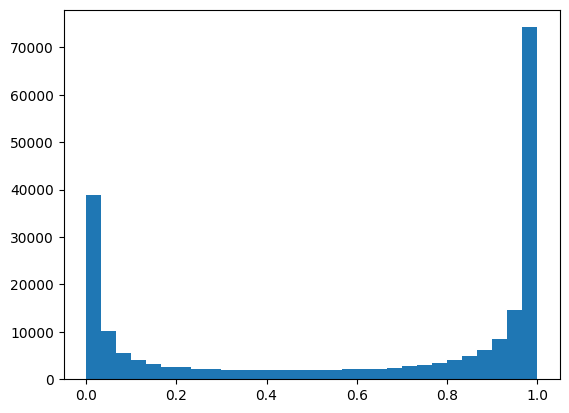

In [14]:
plt.hist(expit(train_pseudo.iloc[:,1:-2].max(axis=1)), bins=30);

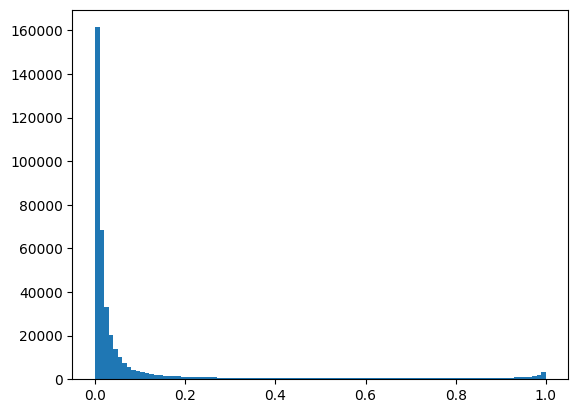

In [19]:
plt.hist(expit(unlabeled_pseudo.iloc[:,1:-2].max(axis=1)), bins=100);

In [16]:
all_google_birds = unlabeled_pseudo.columns[1:-2]

In [26]:
unlabeled_pseudo["all_labels"] = unlabeled_pseudo.apply(
    lambda x: list(all_google_birds[expit(x[all_google_birds].values.astype(np.float32)) > 0.2]), 
    axis=1
)

In [28]:
unlabeled_pseudo["all_labels"] = unlabeled_pseudo["all_labels"].apply(list)

In [31]:
unlabeled_pseudo_for_merge = unlabeled_pseudo.groupby("id").agg({
    "all_labels": list,
    "final_second": list
}).reset_index()

In [32]:
unlabeled_pseudo_for_merge

,id,all_labels,final_second
0,460830,"[[mawthr1], [mawthr1], [mawthr1], [mawthr1], [...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
1,969749,"[[], [], [], [], [], [], [], [], [], [], [], [...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
2,1225526,"[[], [], [grewar3, grnwar1], [], [], [], [], [...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
3,1451354,"[[], [], [whcbar1], [], [], [], [], [], [], []...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
4,1527167,"[[], [], [], [], [], [brcful1, putbab1], [putb...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
...,...,...,...
8439,2147237737,"[[brwowl1], [], [], [brwowl1], [brwowl1], [brw...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
8440,2147319176,"[[], [], [], [], [], [], [], [], [whcbar1], []...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
8441,2147372093,"[[], [], [], [], [], [], [], [], [], [], [], [...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
8442,2147385068,"[[whcbar1], [whcbar1], [], [], [whcbar1], [whc...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."


In [35]:
unlabeled_pseudo_for_merge["filename"] = unlabeled_pseudo_for_merge["id"].apply(lambda x: str(x) + ".ogg")

In [40]:
unlabeled_pseudo_for_merge["duration_s"] = unlabeled_pseudo_for_merge["filename"].apply(
    lambda x: librosa.get_duration(filename=os.path.join("/home/vova/data/exps/birdclef_2024/birdclef_2024/unlabeled_soundscapes", x))
)

/tmp/ipykernel_2996291/2214459338.py:2: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  lambda x: librosa.get_duration(filename=os.path.join("/home/vova/data/exps/birdclef_2024/birdclef_2024/unlabeled_soundscapes", x))


In [44]:
unlabeled_pseudo_for_merge["label_second"] = unlabeled_pseudo_for_merge.apply(create_timewise_label, axis=1)

In [47]:
unlabeled_pseudo_for_merge["label_second"] = unlabeled_pseudo_for_merge["label_second"].apply(merge_intervals)

In [49]:
unlabeled_pseudo_for_merge["label_second"] = unlabeled_pseudo_for_merge.apply(trim_last_label_if_needed, axis=1)

In [50]:
unlabeled_pseudo_for_merge

,id,all_labels,final_second,filename,duration_s,label_second
0,460830,"[[mawthr1], [mawthr1], [mawthr1], [mawthr1], [...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",460830.ogg,240.0,"[[0, 55, [mawthr1]], [60, 70, [comros, mawthr1..."
1,969749,"[[], [], [], [], [], [], [], [], [], [], [], [...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",969749.ogg,240.0,[]
2,1225526,"[[], [], [grewar3, grnwar1], [], [], [], [], [...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",1225526.ogg,240.0,"[[10, 15, [grewar3, grnwar1]]]"
3,1451354,"[[], [], [whcbar1], [], [], [], [], [], [], []...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",1451354.ogg,240.0,"[[10, 15, [whcbar1]], [70, 75, [whcbar1]], [14..."
4,1527167,"[[], [], [], [], [], [brcful1, putbab1], [putb...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",1527167.ogg,240.0,"[[25, 50, [putbab1, brcful1]], [55, 60, [crbsu..."
...,...,...,...,...,...,...
8439,2147237737,"[[brwowl1], [], [], [brwowl1], [brwowl1], [brw...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",2147237737.ogg,240.0,"[[0, 5, [brwowl1]], [15, 30, [brwowl1]], [40, ..."
8440,2147319176,"[[], [], [], [], [], [], [], [], [whcbar1], []...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",2147319176.ogg,240.0,"[[40, 45, [whcbar1]], [230, 235, [mawthr1]]]"
8441,2147372093,"[[], [], [], [], [], [], [], [], [], [], [], [...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",2147372093.ogg,240.0,[]
8442,2147385068,"[[whcbar1], [whcbar1], [], [], [whcbar1], [whc...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",2147385068.ogg,240.0,"[[0, 10, [whcbar1]], [20, 40, [whcbar1]], [45,..."


In [56]:
unlabeled_pseudo_for_merge_nonempt = unlabeled_pseudo_for_merge[unlabeled_pseudo_for_merge["label_second"].apply(len) > 0].reset_index(drop=True)

In [58]:
unlabeled_pseudo_for_merge_nonempt["dataset"] = "soundscape"
unlabeled_pseudo_for_merge_nonempt["url"] = "empty_url"
unlabeled_pseudo_for_merge_nonempt["secondary_labels"] = "[]"

In [59]:
unlabeled_pseudo_for_merge_nonempt

,id,all_labels,final_second,filename,duration_s,label_second,dataset,url,secondary_labels
0,460830,"[[mawthr1], [mawthr1], [mawthr1], [mawthr1], [...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",460830.ogg,240.0,"[[0, 55, [mawthr1]], [60, 70, [comros, mawthr1...",soundscape,empty_url,[]
1,1225526,"[[], [], [grewar3, grnwar1], [], [], [], [], [...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",1225526.ogg,240.0,"[[10, 15, [grewar3, grnwar1]]]",soundscape,empty_url,[]
2,1451354,"[[], [], [whcbar1], [], [], [], [], [], [], []...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",1451354.ogg,240.0,"[[10, 15, [whcbar1]], [70, 75, [whcbar1]], [14...",soundscape,empty_url,[]
3,1527167,"[[], [], [], [], [], [brcful1, putbab1], [putb...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",1527167.ogg,240.0,"[[25, 50, [putbab1, brcful1]], [55, 60, [crbsu...",soundscape,empty_url,[]
4,1653006,"[[], [], [], [], [], [], [], [], [], [], [], [...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",1653006.ogg,240.0,"[[60, 65, [brwowl1]]]",soundscape,empty_url,[]
...,...,...,...,...,...,...,...,...,...
4572,2146228323,"[[], [], [crseag1], [crseag1], [], [bwfshr1], ...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",2146228323.ogg,240.0,"[[10, 20, [crseag1]], [25, 30, [bwfshr1]], [21...",soundscape,empty_url,[]
4573,2147237737,"[[brwowl1], [], [], [brwowl1], [brwowl1], [brw...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",2147237737.ogg,240.0,"[[0, 5, [brwowl1]], [15, 30, [brwowl1]], [40, ...",soundscape,empty_url,[]
4574,2147319176,"[[], [], [], [], [], [], [], [], [whcbar1], []...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",2147319176.ogg,240.0,"[[40, 45, [whcbar1]], [230, 235, [mawthr1]]]",soundscape,empty_url,[]
4575,2147385068,"[[whcbar1], [whcbar1], [], [], [whcbar1], [whc...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...",2147385068.ogg,240.0,"[[0, 10, [whcbar1]], [20, 40, [whcbar1]], [45,...",soundscape,empty_url,[]


In [64]:
unlabeled_pseudo_for_merge_nonempt["primary_label"] = unlabeled_pseudo_for_merge_nonempt["label_second"].apply(lambda x: most_frequent_element(
    list(chain(*[el[-1] for el in x]))
))

In [74]:
unlabeled_pseudo_for_merge_nonempt["stratify_col"] = unlabeled_pseudo_for_merge_nonempt["primary_label"]

In [67]:
vc  = unlabeled_pseudo_for_merge_nonempt["primary_label"].value_counts()

In [53]:
missing_birds_after_filter = (
    set(scored_birds) - set(chain(*unlabeled_pseudo_for_merge["label_second"].apply(lambda x: list(chain(*[el[-1] for el in x]))).to_list()))
)
new_birds = (
    set(chain(*unlabeled_pseudo_for_merge["label_second"].apply(lambda x: list(chain(*[el[-1] for el in x]))).to_list())) - set(scored_birds)
)
missing_birds_after_filter

{'ashwoo2',
 'asiope1',
 'aspswi1',
 'bkrfla1',
 'blaeag1',
 'brasta1',
 'brwjac1',
 'dafbab1',
 'darter2',
 'greegr',
 'gryfra',
 'heswoo1',
 'indrob1',
 'indrol2',
 'inpher1',
 'integr',
 'isbduc1',
 'jerbus2',
 'kerlau2',
 'lesyel1',
 'lewduc1',
 'marsan',
 'oripip1',
 'paisto1',
 'piebus1',
 'piekin1',
 'purswa3',
 'rossta2',
 'rutfly6',
 'whbwag1',
 'whiter2'}

In [71]:
needed_additional_classes = vc[vc < 10].index.to_list() + list(missing_birds_after_filter)

In [90]:
prepared_train_metadata_google_bird = pd.read_csv(
    "/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv1_GBirdV1.csv"
)

In [89]:
needed_additional_classes = set(needed_additional_classes) | (set(scored_birds) - set(unlabeled_pseudo_for_merge_nonempt["primary_label"]))

In [91]:
prepared_train_metadata_google_bird = prepared_train_metadata_google_bird[prepared_train_metadata_google_bird["primary_label"].isin(needed_additional_classes)].reset_index(drop=True)

In [92]:
set(unlabeled_pseudo_for_merge_nonempt.columns) & set(prepared_train_metadata_google_bird.columns)

{'all_labels',
 'duration_s',
 'filename',
 'final_second',
 'id',
 'label_second',
 'primary_label',
 'secondary_labels',
 'stratify_col',
 'url'}

In [93]:
# unlabeled_pseudo_for_merge_nonempt.to_csv("../google_bird_predictions/unlabeled_data/processed_data_v1.csv", index=False)
prepared_train_metadata_google_bird.to_csv("../google_bird_predictions/unlabeled_data/processed_data_v1_add_train.csv", index=False)